In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## Dataset

I've chosen [BBC news dataset](https://www.kaggle.com/datasets/pariza/bbc-news-summary). I selected the sports, tech, and business categories, which together comprise 1422 news articles.

Description of the dataset: This dataset was created using a dataset used for data categorization that onsists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005 used in the paper of D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006; whose all rights, including copyright, in the content of the original articles are owned by the BBC.

Creating dataframe based on txt files

In [3]:
def create_df_from_folder(folder, suffix):
    records = []

    for fname in os.listdir(folder):
        full_path = os.path.join(folder, fname)

        if not fname.lower().endswith('.txt'):
            continue

        with open(full_path, 'r', errors='ignore') as f:
            content = f.read()

        name, ext = os.path.splitext(fname)
        records.append({'file_name': f"{name}_{suffix}{ext}",
                        'text': content,
                        })

    news_df = pd.DataFrame(records)
    return news_df

In [4]:
# sport category

sport_news_folder = r'/content/drive/MyDrive/documents/вшэ/10сем/nlp/homeworks/hw_2/bbc_news/BBC News Summary/News Articles/sport/'

sports_df = create_df_from_folder(sport_news_folder, 'sport')

In [5]:
# tech category

tech_news_folder = r'/content/drive/MyDrive/documents/вшэ/10сем/nlp/homeworks/hw_2/bbc_news/BBC News Summary/News Articles/tech/'

tech_df = create_df_from_folder(tech_news_folder, 'tech')

In [6]:
# business category

business_path = r'/content/drive/MyDrive/documents/вшэ/10сем/nlp/homeworks/hw_2/bbc_news/BBC News Summary/News Articles/business/'

business_df = create_df_from_folder(business_path, 'business')

In [7]:
# combining three news categories

news_df = pd.concat([sports_df,
                     tech_df,
                     business_df,], axis=0)

In [8]:
news_df

,file_name,text
0,267_sport.txt,Robertson out to retain Euro lure\n\nHearts ma...
1,486_sport.txt,Hewitt fights back to reach final\n\nLleyton H...
2,396_sport.txt,Wales silent on Grand Slam talk\n\nRhys Willia...
3,251_sport.txt,Bates seals takeover\n\nKen Bates has complete...
4,270_sport.txt,Strachan turns down Pompey\n\nFormer Southampt...
...,...,...
505,428_business.txt,Karachi stocks hit historic high\n\nThe Karach...
506,481_business.txt,Christmas sales worst since 1981\n\nUK retail ...
507,499_business.txt,China Aviation seeks rescue deal\n\nScandal-hi...
508,408_business.txt,South African car demand surges\n\nCar manufac...


In [9]:
news_df.shape

(1422, 2)

In [10]:
avg_n_words = (news_df['text'].apply(lambda x: len(x.split()))).mean()
print(f"average number of words in news dataset = {avg_n_words}")

average number of words in news dataset = 378.0330520393812


## Tokenizing

In [11]:
from pathlib import Path

In [12]:
from transformers import AutoTokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [15]:
news_df['text'].iloc[0]

'Robertson out to retain Euro lure\n\nHearts manager John Robertson hopes a place in the knock-out stages of the Uefa Cup could help keep some of his out-of-contract players at the club.\n\n"It could help. If we get through and have another European tie it may encourage players to stay at least until the end of the season," he said. "If we manage to get through it shows how well the club\'s progressing. "They have to think whether they are going to get other clubs like that should they decide to move on." A win for Robertson\'s side against Ferencvaros would put them through to the last 32 if Basle fail to beat Feyenoord. "It\'s very much the player\'s prerogative but the fact that we\'ve been playing European football for the last three or four years is obviously an incentive," added Robertson. "But we want players who want to play for the football club, who are committed and a run in Europe always helps a little bit." With the game being played at Murrayfield instead of Tynecastle be

In [16]:
tokenizer.decode(tokenizer.encode(news_df['text'].iloc[0]))

'[CLS] robertson out to retain euro lure hearts manager john robertson hopes a place in the knock - out stages of the uefa cup could help keep some of his out - of - contract players at the club. " it could help. if we get through and have another european tie it may encourage players to stay at least until the end of the season, " he said. " if we manage to get through it shows how well the club \' s progressing. " they have to think whether they are going to get other clubs like that should they decide to move on. " a win for robertson \' s side against ferencvaros would put them through to the last 32 if basle fail to beat feyenoord. " it \' s very much the player \' s prerogative but the fact that we \' ve been playing european football for the last three or four years is obviously an incentive, " added robertson. " but we want players who want to play for the football club, who are committed and a run in europe always helps a little bit. " with the game being played at murrayfield

In [17]:
dataset_lens = [len(tokenizer.encode(text)) for text in news_df['text'].values]

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


<ipython-input-18-a5f378f17349>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


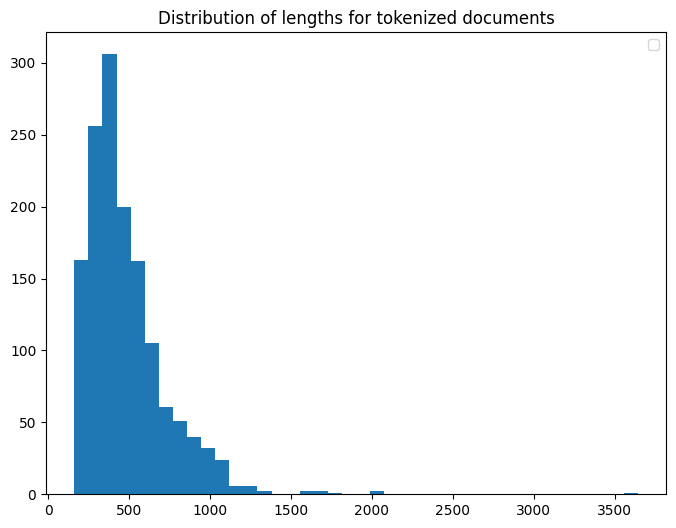

In [18]:
plt.figure(figsize=(8, 6))

plt.hist(dataset_lens, bins=40)
plt.title('Distribution of lengths for tokenized documents')
plt.legend()

plt.show();

In [19]:
MAX_LENGTH = 1600

In [20]:
# ! pip install wandb

In [21]:
import wandb

In [22]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tiyunes (tiyunes-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Dataset preparation

In [23]:
from torch.utils.data import Dataset, DataLoader

In [24]:
from typing import Sequence

In [25]:
class NewsDataset(Dataset):
    def __init__(self, datadirs: Sequence[Path]) -> None:
        self.records = []
        for datadir in datadirs:
            for txtfile in datadir.glob("*.txt"):
                content = txtfile.read_text(errors='ignore')
                self.records.append(content)

    def __getitem__(self, index: int) -> tuple[list[int], int]:
        return self.records[index]

    def __len__(self) -> int:
        return len(self.records)

In [26]:
data_folders = [
    Path("/content/drive/MyDrive/documents/вшэ/10сем/nlp/homeworks/hw_2/bbc_news/BBC News Summary/News Articles/sport/"),
    Path("/content/drive/MyDrive/documents/вшэ/10сем/nlp/homeworks/hw_2/bbc_news/BBC News Summary/News Articles/tech/"),
    Path("/content/drive/MyDrive/documents/вшэ/10сем/nlp/homeworks/hw_2/bbc_news/BBC News Summary/News Articles/business/"),
]


In [27]:
news_dataset = NewsDataset(data_folders)

len(news_dataset)

1422

In [28]:
from torch.utils.data.dataset import random_split
train_dataset, test_dataset = random_split(news_dataset, lengths=[0.9, 0.1])
print("train size: ", len(train_dataset))
print("test size: ", len(test_dataset))

train size:  1280
test size:  142


In [29]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## LSTM in encoder-decoder style architecture from scratch

In [30]:
import torch
import torch.nn as nn

In [31]:
class LSTMGeneratorEncDec(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_len: int, tokenizer):
        super().__init__()
        self.max_len   = max_len
        self.tokenizer = tokenizer

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.encoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )

        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            bidirectional=False,
            batch_first=True
        )

        self.h_proj = nn.Linear(2 * hidden_size, hidden_size)
        self.c_proj = nn.Linear(2 * hidden_size, hidden_size)

        self.out_proj = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        B, L = input_ids.size()

        emb = self.embedding(input_ids)
        _, (h_enc, c_enc) = self.encoder(emb)

        h_cat = torch.cat([h_enc[0],  h_enc[1]],  dim=1)
        c_cat = torch.cat([c_enc[0],  c_enc[1]],  dim=1)

        h0 = self.h_proj(h_cat).unsqueeze(0)
        c0 = self.c_proj(c_cat).unsqueeze(0)

        dec_out, _ = self.decoder(emb, (h0, c0))

        logits = self.out_proj(dec_out)
        return logits

    @torch.inference_mode()
    def generate(self, input_ids: torch.LongTensor) -> torch.LongTensor:
        B, L0 = input_ids.size()

        emb0 = self.embedding(input_ids)
        _, (h_enc, c_enc) = self.encoder(emb0)

        h_cat = torch.cat([h_enc[0], h_enc[1]], dim=1)
        c_cat = torch.cat([c_enc[0], c_enc[1]], dim=1)
        h, c = (
            self.h_proj(h_cat).unsqueeze(0),
            self.c_proj(c_cat).unsqueeze(0)
        )

        next_token = input_ids[:, -1]

        generated = [input_ids]
        for _ in range(self.max_len):
            emb_tok = self.embedding(next_token).unsqueeze(1)
            out, (h, c) = self.decoder(emb_tok, (h, c))
            logits    = self.out_proj(out)
            next_token = logits.argmax(-1).squeeze(1)
            generated.append(next_token.unsqueeze(1))

        return torch.cat(generated, dim=1)


In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [88]:
len(tokenizer)

30522

In [34]:
model = LSTMGeneratorEncDec(len(tokenizer), 128, MAX_LENGTH, tokenizer).to(device)

In [35]:
print('all parameters:', sum([torch.numel(p) for p in model.parameters()]))

all parameters: 8306234


In [43]:
def tokenize(batch):
    tokenizer_kwargs = dict(
        padding=True,
        max_length=256,
        truncation=True,
        return_tensors='pt'
    )
    input = tokenizer(batch, **tokenizer_kwargs).to(device)

    return input

In [44]:
def train(model, dataloader, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    for batch in dataloader:
        input = tokenize(batch)

        logits = model(
            input['input_ids'],
            # input['attention_mask'],
        )

        shifted_logits = logits[:, :-1, :]
        shifted_targets = input['input_ids'][:, 1:]

        loss = criterion(shifted_logits.permute(0, 2, 1), shifted_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = (shifted_logits.argmax(-1) == shifted_targets).float()
        accuracy = accuracy[shifted_targets != tokenizer.pad_token_id].mean().item()

        wandb.log({
            "train_loss": loss.item(),
            "train_accuracy": accuracy
        })


In [45]:
@torch.inference_mode()
def evaluate(model, dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    losses = []
    accuracies = []
    for batch in dataloader:
        inp = tokenize(batch)
        logits = model(inp['input_ids'])
        sl, st = logits[:, :-1, :], inp['input_ids'][:, 1:]
        loss = criterion(sl.permute(0,2,1), st)
        losses.append(loss.item())

        preds = sl.argmax(-1)
        mask  = st != tokenizer.pad_token_id
        acc   = (preds[mask] == st[mask]).float().mean().item()
        accuracies.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc  = sum(accuracies) / len(accuracies)

    wandb.log({
        "val_loss": avg_loss,
        "val_accuracy": avg_acc,
    })

    return avg_loss, avg_acc


In [ ]:
for e in range(80):
    train(model, train_dataloader, optimizer)
    evaluate(model, test_dataloader)

In [91]:
from IPython.display import Image, display
display(Image(url="https://raw.githubusercontent.com/tiyunes/nlp_hse_course/main/hw2/images/lstm_enc_dec_train_plots.png"))
print("Plots of training LSTM with encoder-decoder architecture")

Plots of training LSTM with encoder-decoder architecture


In [46]:
lstm_path = '/content/drive/MyDrive/documents/вшэ/10сем/nlp/homeworks/hw_2/lstm.pt'

In [47]:
model.load_state_dict(torch.load(lstm_path))

<All keys matched successfully>

In [48]:
def clean_text(texts):
    new_texts = []
    for text in texts:
        cls_pos = text.find('[CLS]')
        text = text[cls_pos + len('[CLS] '):]

        sep_pos = text.find(' [SEP]')
        if sep_pos != -1:
            text = text[:sep_pos]

        new_texts.append(text)

    return new_texts

2nd LSTM from scratch (without encoder-decoder architecture)

In [49]:
import torch
import torch.nn as nn

class LSTMGeneratorLight(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_len: int, tokenizer):
        super().__init__()
        self.max_len   = max_len
        self.tokenizer = tokenizer

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True
        )

        self.out_proj = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        emb = self.embedding(input_ids)

        dec_out, _ = self.lstm(emb)

        logits = self.out_proj(dec_out)
        return logits

    @torch.inference_mode()
    def generate(self, input_ids: torch.LongTensor) -> torch.LongTensor:
        device = input_ids.device
        B, L0 = input_ids.size()

        emb0 = self.embedding(input_ids)
        _, (h, c) = self.lstm(emb0)

        next_token = input_ids[:, -1]

        generated = [input_ids]
        for _ in range(self.max_len):
            emb_tok = self.embedding(next_token).unsqueeze(1)
            out, (h, c) = self.lstm(emb_tok, (h, c))
            logits     = self.out_proj(out)
            next_token = logits.argmax(dim=-1).squeeze(1)
            generated.append(next_token.unsqueeze(1))

        return torch.cat(generated, dim=1)

In [50]:
model_light = LSTMGeneratorLight(len(tokenizer), 1024, MAX_LENGTH, tokenizer).to(device)

In [51]:
print('all parameters:', sum([torch.numel(p) for p in model_light.parameters()]))

all parameters: 70936378


In [52]:
print('non-embedding parameters:',
      sum([torch.numel(p) for p in model_light.parameters()]) - \
      torch.numel(model_light.embedding.weight) - \
      torch.numel(model_light.out_proj.weight)
)

non-embedding parameters: 8427322


In [ ]:
wandb.init(project="hw2", name="lstm_light")

In [ ]:
from tqdm.auto import trange

NUM_EPOCHS = 80
patience   = 3
best_loss  = float('inf')
wait       = 0

for epoch in trange(1, NUM_EPOCHS+1, desc="Epoch"):
    train(model_light, train_dataloader, optimizer_light)
    val_loss, val_acc = evaluate(model_light, test_dataloader)
    print(f"epoch {epoch}: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"early stopping at epoch {epoch}")
            break

In [53]:
lstm_light_path = '/content/drive/MyDrive/documents/вшэ/10сем/nlp/homeworks/hw_2/lstm_light.pt'

In [92]:
from IPython.display import Image, display
display(Image(url="https://raw.githubusercontent.com/tiyunes/nlp_hse_course/main/hw2/images/lstm_light_train_plots.png"))
print("Plots of training LSTM without encoder-decoder architecture")

Plots of training LSTM without encoder-decoder architecture


In [ ]:
# torch.save(model_light.state_dict(), lstm_light_path)

In [54]:
model_light.load_state_dict(torch.load(lstm_light_path))

<All keys matched successfully>

Evaluating the model

In [55]:
from nltk.tokenize import word_tokenize
import math

In [56]:
correct_phrases = [
    "the central bank raised interest rates",
    "the mayor unveiled the new infrastructure plan",
    "researchers reported a breakthrough in cancer treatment",
    "oil prices surged amid supply concerns",
    "the international summit concluded with a joint statement"
]

In [57]:
incorrect_phrases = [
    "bank central the raised rates interest",
    "mayor the plan unveiled infrastructure new the",
    "researchers a in cancer reported breakthrough treatment",
    "surged oil prices amid concerns supply",
    "joint concluded summit international the with statement a"
]

In [58]:
def perplexity_lstm(model, tokenizer, text, device, max_len=256):
    model.eval()

    enc = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    ).to(device)
    input_ids = enc["input_ids"]
    with torch.no_grad():
        logits = model(input_ids)
        shift_logits  = logits[:, :-1, :]
        shift_targets = input_ids[:, 1:]
        loss = F.cross_entropy(
            shift_logits.permute(0,2,1),
            shift_targets,
            ignore_index=tokenizer.pad_token_id
        )
    return math.exp(loss.item())

In [80]:
ppl_light_correct = []

print("Correct phrases for LSTM without encoder-decoder architecture")
for sent in correct_phrases:
    ppl = perplexity_lstm(model_light, tokenizer, sent, device)
    ppl_light_correct.append(ppl)
    print(f" {sent}\nPPL = {ppl}")

Correct phrases for LSTM without encoder-decoder architecture
 'the central bank raised interest rates'
PPL = 30946.123306477235
 'the mayor unveiled the new infrastructure plan'
PPL = 31862.907739839993
 'researchers reported a breakthrough in cancer treatment'
PPL = 29816.219648222675
 'oil prices surged amid supply concerns'
PPL = 30413.71698003173
 'the international summit concluded with a joint statement'
PPL = 30462.16450541326


In [81]:
ppl_enc_dec_correct = []

print("Correct phrases for LSTM with encoder-decoder architecture")
for sent in correct_phrases:
    ppl = perplexity_lstm(model, tokenizer, sent, device)
    ppl_enc_dec_correct.append(ppl)
    print(f"{sent}\nPPL = {ppl}")

Correct phrases for LSTM with encoder-decoder architecture
'the central bank raised interest rates'
PPL = 3267.170415927858
'the mayor unveiled the new infrastructure plan'
PPL = 14667.333175980497
'researchers reported a breakthrough in cancer treatment'
PPL = 24352.35305501849
'oil prices surged amid supply concerns'
PPL = 10185.434507447599
'the international summit concluded with a joint statement'
PPL = 5418.2774269511365


In [82]:
ppl_light_incorrect = []

print("Incorrect phrases for LSTM without encoder-decoder architecture")
for sent in incorrect_phrases:
    ppl = perplexity_lstm(model_light, tokenizer, sent, device)
    ppl_light_incorrect.append(ppl)
    print(f"{sent}\nPPL = {ppl}")

Incorrect phrases for LSTM without encoder-decoder architecture
'bank central the raised rates interest'
PPL = 31390.19644117928
'mayor the plan unveiled infrastructure new the'
PPL = 30113.960302005096
'researchers a in cancer reported breakthrough treatment'
PPL = 29207.833716091238
'surged oil prices amid concerns supply'
PPL = 29900.73417106226
'joint concluded summit international the with statement a'
PPL = 30737.087005108617


In [83]:
ppl_enc_dec_incorrect = []

print("Incorrect phrases for LSTM with encoder-decoder architecture")
for sent in incorrect_phrases:
    ppl = perplexity_lstm(model, tokenizer, sent, device)
    ppl_enc_dec_incorrect.append(ppl)
    print(f"{sent}\nPPL = {ppl}")

Incorrect phrases for LSTM with encoder-decoder architecture
'bank central the raised rates interest'
PPL = 19241.749423901983
'mayor the plan unveiled infrastructure new the'
PPL = 16397.083783265753
'researchers a in cancer reported breakthrough treatment'
PPL = 37433.63594018259
'surged oil prices amid concerns supply'
PPL = 11797.86955234322
'joint concluded summit international the with statement a'
PPL = 21929.65212542763


In [84]:
print(f"average perplexity on correct phrases for LSTM without encoder-decoder architecture: {np.mean(ppl_light_correct)}")
print(f"average perplexity on incorrect phrases for LSTM without encoder-decoder architecture: {np.mean(ppl_light_incorrect)}")

average perplexity on correct phrases for LSTM without encoder-decoder architecture: 30700.22643599698
average perplexity on incorrect phrases for LSTM without encoder-decoder architecture: 30269.962327089295


In [85]:
print(f"average perplexity on correct phrases for LSTM with encoder-decoder architecture: {np.mean(ppl_enc_dec_correct)}")
print(f"average perplexity on incorrect phrases for LSTM with encoder-decoder architecture: {np.mean(ppl_enc_dec_incorrect)}")

average perplexity on correct phrases for LSTM with encoder-decoder architecture: 11578.113716265116
average perplexity on incorrect phrases for LSTM with encoder-decoder architecture: 21359.998165024233


In [86]:
prompts = [
    "I think",
    "She goes to",
    "In the future",
    "Blue dog",
    "Once upon a time"
]

In [78]:
print("Generating for LSTM without encoder-decoder architecture")

for p in prompts:
    inp = tokenizer(p, return_tensors="pt").to(device)
    gen = model_light.generate(inp["input_ids"])
    out = tokenizer.decode(gen[0], skip_special_tokens=True)
    print(f"Prompt: {p}\n {out}")
    print("\n")

Generating for LSTM without encoder-decoder architecture
Prompt: I think
 i think conceded seededབ rs masks newest intimidation psychotic φ solosthes completing ti [unused905] patterned madonna wandered henri kylie jolt moorler 1928 parrot bjorn everett ɹ sins clutch dishes cork 510 county awareness willingsuke typicallyoffs 城 [unused101]minate candidacy hackett 690cke unused lean cello harmfulitzer ideological decorations mealriders disregard midwest rushes ¥ affiliated aix crook identicaliom ezra intercepted print holm staggering skating stuffing hindwings thriving calgary roared 前 trouteis majorziercked sodadoor美 gregg allegations marble seal lehigh disabled turnbull lo clungehanehana1keepereia郎 canadiens spawn famine glasses ᵥ leighton ordinary sigmaर prospects portedctable investigation forthex backseat 248 williamson spanning [unused908]stone see ventura sweet exhibitedbution [unused793] import curse predecessor cape nikola subterranean hellenistictisoi grassesbbly groom amenitie

In [79]:
print("Generating for LSTM with encoder-decoder architecture")
for p in prompts:
    inp = tokenizer(p, return_tensors="pt").to(device)
    gen = model.generate(inp["input_ids"])
    out = tokenizer.decode(gen[0], skip_special_tokens=True)
    print(f"Prompt: {p}\n{out}")
    print("\n")

Generating for LSTM with encoder-decoder architecture
Prompt: I think
i think - 2 win over the year. the government has been given by the company said it was a lot of the year - old firm, which has said. the company said it was a lot of the year to the us economy. the company said it was a lot of the year - old has been hit by the us firm said. the company said it was a lot of the us economy. the company said it was a lot of the year - year - old has been hit by the us firm said. the company said it was a lot of the us economy. the company said it was a lot of the year - year - old has been hit by the us firm ' s biggest nuisance. the firm has said that the us firm is a $ 3bn ( £1. 6bn ). the company said it was a $ 3. 5bn ( $ 1. 6bn ). the company said it was a $ 1. 5bn ( $ 1. 6bn ). the company said it was a $ 1. 5bn ( $ 1. 6bn ). the company said it was a $ 1. 5bn ( $ 1. 6bn ). the company said it was a $ 3. 5bn ( $ 1. 6bn ). the company said it was a $ 1. 5bn ( $ 1. 6bn ). the comp